Toy dataset 02 at a higher resolution and backwards in time to be applied for the diagnostics of:
* Finite Time Lyapunov Exponents
* Finite Time Coherent Sets

# To dos:
* dt = -25 mins --> check 

(background in time)


# Simulation charactersitics:
* Runtime: 30 days (backwards in time).  FTCS requires thet there is enought mixing in the domain for it to detect the coherent structures.
* Particles released: SMOC spatial resolution is 1/12, so release of x4 that (1/48) to get subgrid dynamics.
* Region : west of retroflection (to have coherent eddies).

### Sample UV based on:
https://github.com/sruehs/IMMERSE_waves/blob/develop-mac/code/Parcels_CalcTraj_v2tau.ipynb

# To improve:
* add indices to not load all global dataset and increase speed

In [1]:
import matplotlib.pyplot as plt 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker

import xarray as xr
# import trajan as ta

In [2]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta, datetime

from operator import attrgetter

# Exploring one input file to define region of release:

In [3]:
filedir = '/storage/shared/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/'

In [4]:
ds_m = xr.open_mfdataset(filedir + 'SMOC_20210[1-2]*')


In [5]:
ds_m

,Array,Chunk
Bytes,46.51 GiB,807.23 MiB
Shape,"(1416, 1, 2041, 4320)","(24, 1, 2041, 4320)"
Count,177 Tasks,59 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,46.51 GiB,807.23 MiB
Shape,"(1416, 1, 2041, 4320)","(24, 1, 2041, 4320)"
Count,177 Tasks,59 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


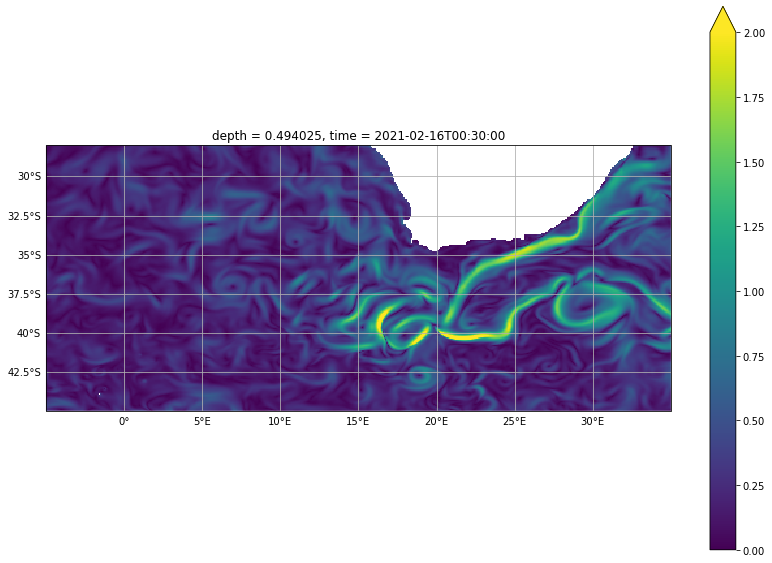

In [6]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,:,:])**2 + (ds_m.vo[46*24,0,:,:])**2).plot(vmax=2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-5, 35])
ax1.set_ylim([-45, -28])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Zoom in:

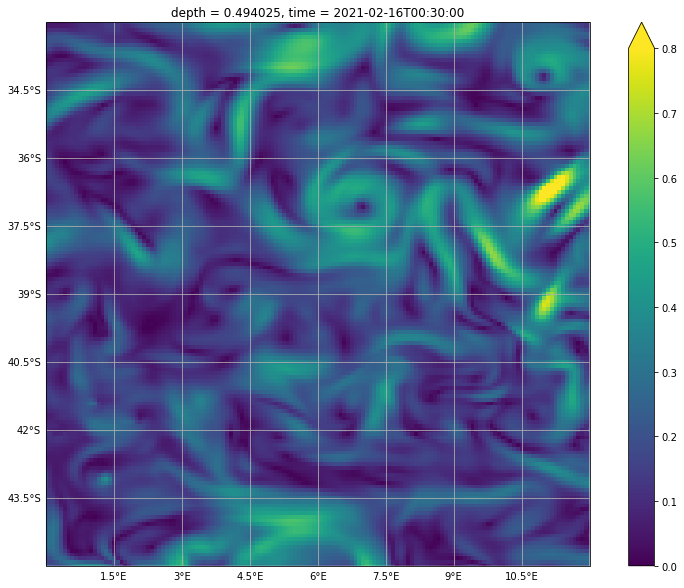

In [36]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,:,:])**2 + (ds_m.vo[46*24,0,:,:])**2).plot(vmax=.8) #1.2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([0, 12])
ax1.set_ylim([-33-12, -33])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

We choose a region west of the retroflection where more coherent eddies can be observed

Checking the indices:

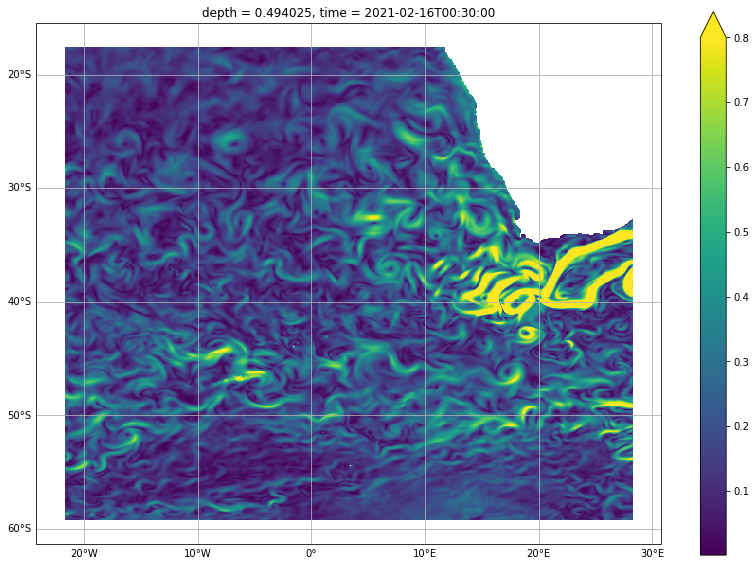

In [20]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,250:750,1900:2500])**2 + (ds_m.vo[46*24,0,250:750,1900:2500])**2).plot(vmax=.8) #1.2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
# ax1.set_xlim([0, 12])
# ax1.set_ylim([-33-12, -33])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Launching the simulation:

In [7]:
# Lorenz directory
filedir = '/storage/shared/oceanparcels/input_data/CMEMS/'


In [8]:
filenames = {'U': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*",
             'V': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*"}

## we use the eulerian velocity (uo and vo):

In [9]:
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [10]:
# fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, chunksize='auto') # --> slow with this

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices={'longitude': range(1900, 2500), 'latitude': range(250, 750)}, chunksize=False)

# Releasing particles in a regular grid:
Particles released with a resolution x4 the resolution of the input data (1/12˚), so 1/48˚.


In [11]:
lon_min = 0.
lon_max = 12.

lat_min = -45.
lat_max = -33.

In [12]:
step = 1./48

lons, lats = np.meshgrid(np.arange(lon_min, lon_max+step, step), np.arange(lat_min, lat_max+step, step))

In [13]:
pclass=JITParticle

class UVParticle(pclass):
    U = Variable('U', dtype=np.float32, initial=np.nan)
    V = Variable('V', dtype=np.float32, initial=np.nan)

In [14]:
pset = ParticleSet(fieldset=fieldset, pclass=UVParticle, lon=lons, lat=lats, time=datetime(2021, 2, 16, 0, 0)) #30


In [15]:
def DeleteParticle(particle, fieldset, time):
    particle.delete

In [16]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

In [17]:
output_filename = "toy_data_02.nc"

In [18]:

output_file = pset.ParticleFile(name=output_filename, outputdt=timedelta(hours=6))
pset.execute(pset.Kernel(AdvectionRK4) + pset.Kernel(SampleUV),
             runtime=timedelta(days=30),
             dt=timedelta(minutes=-25), # back in time
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=output_file)

INFO: Compiled ArrayUVParticleAdvectionRK4SampleUV ==> /tmp/parcels-319202/lib37f8285bab985417cdcb250f370eab44_0.so
INFO: Temporary output files are stored in out-XYVWFVBW.
INFO: You can use "parcels_convert_npydir_to_netcdf out-XYVWFVBW" to convert these to a NetCDF file during the run.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2592000.0/2592000.0 [22:48<00:00, 1894.13it/s]


In [19]:
output_file.export()


In [20]:
ds = xr.open_dataset(output_filename)

In [21]:
ds

<xarray.Dataset>
Dimensions:     (traj: 334084, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    lon         (traj, obs) float32 ...
    lat         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.2-3-g366d4707
    parcels_mesh:           spherical

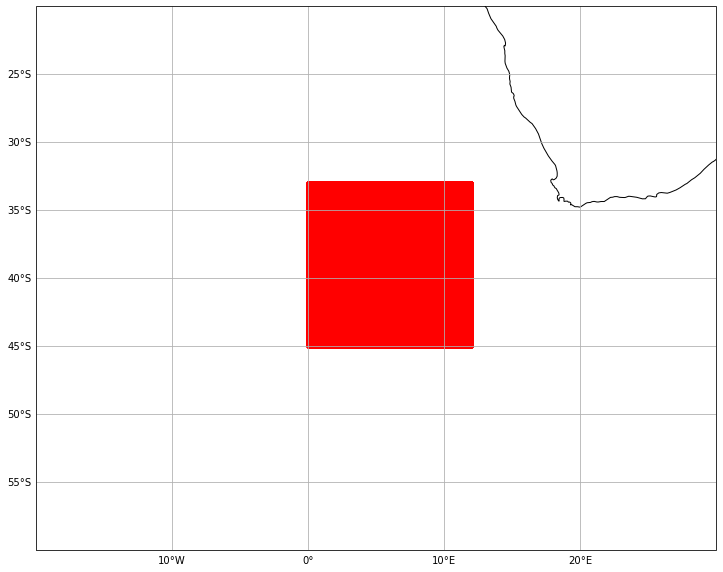

In [26]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-20, 30])
ax1.set_ylim([-60, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

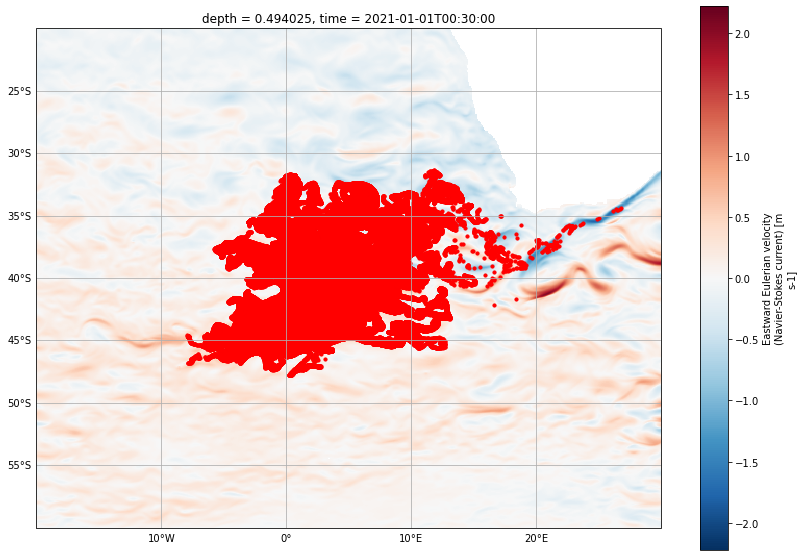

In [27]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ds_m.uo[0,0,:,:].plot()
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-20, 30])
ax1.set_ylim([-60, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Plotting 1/100 trajectories:

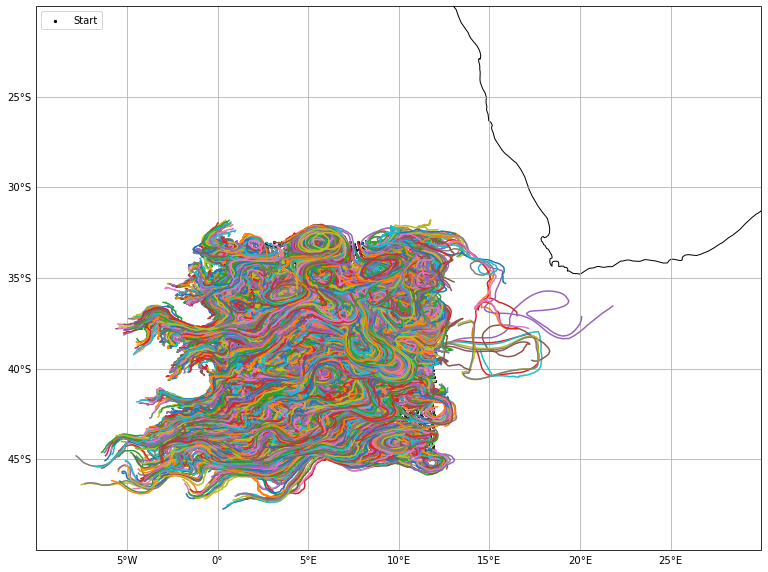

In [68]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'][0::100,:].T, ds['lat'][0::100,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][0::100,0], ds['lat'][0::100,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-10, 30])
ax1.set_ylim([-50, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
ax1.legend(loc=2)

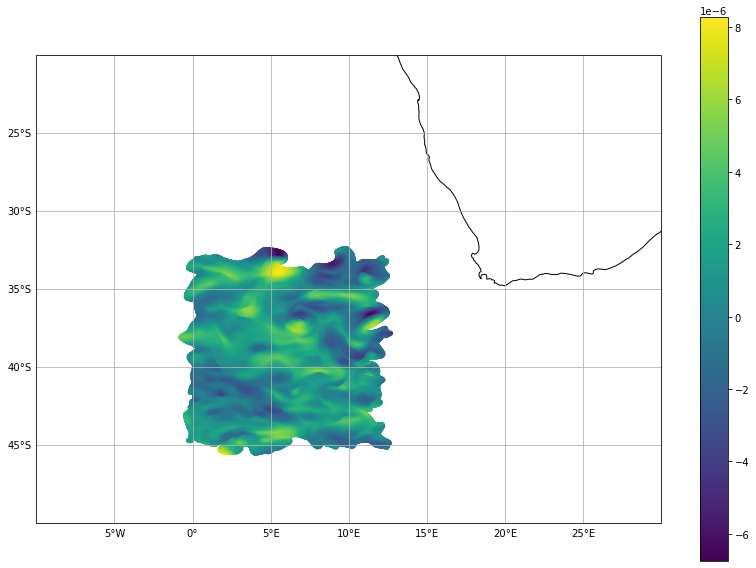

In [70]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][:,10], ds['lat'][:,10], c=ds.U[:,10], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-10, 30])
ax1.set_ylim([-50, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

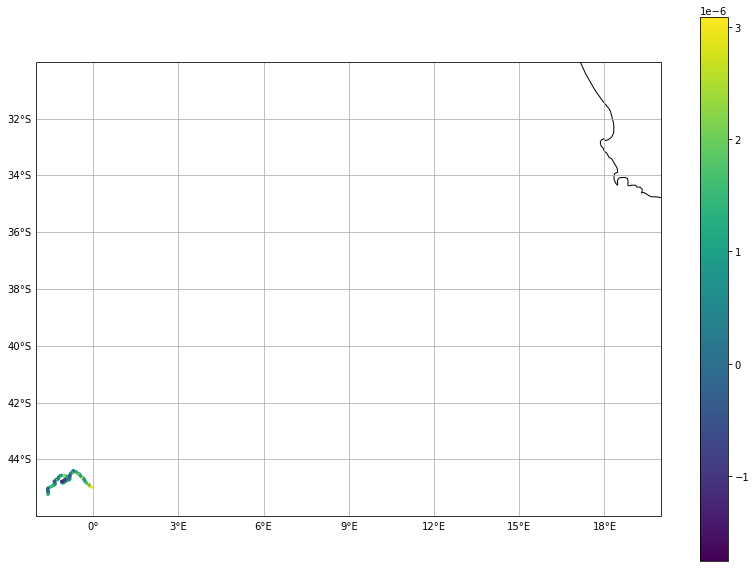

In [44]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][0,:], ds['lat'][0,:], c=ds.U[0,:], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-2, 20])
ax1.set_ylim([-46, -30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# --> units in degrees/s

In [37]:
def calc_trajspeed(trajset):
    """
    Obtain vel. in m/s
    1852*60 is ....
    """
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60 
    speed = (u**2 + v**2)**(1/2)
    return speed

In [38]:
speed = calc_trajspeed(ds)


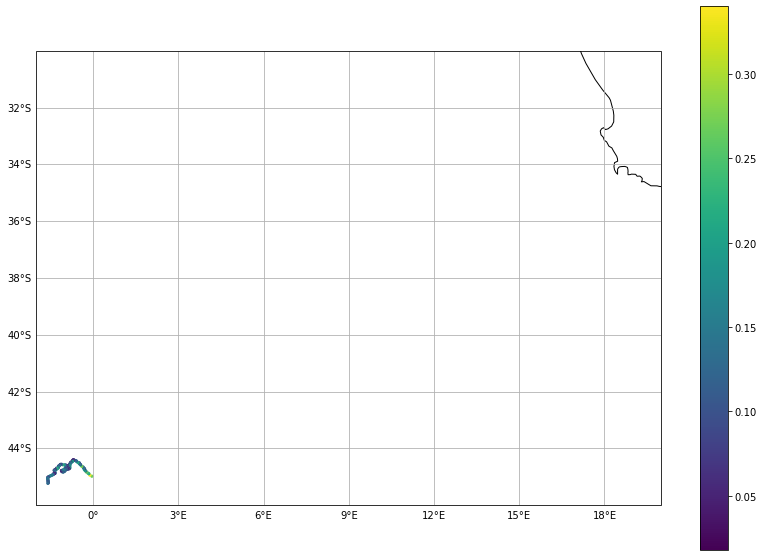

In [45]:

plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][0,:], ds['lat'][0,:], c=speed[0,:], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-2, 20])
ax1.set_ylim([-46, -30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

In [40]:
speed

<xarray.DataArray (traj: 334084, obs: 121)>
array([[       nan, 0.26887953, 0.34001562, ..., 0.14870101, 0.0938759 ,
        0.12757945],
       [       nan, 0.2700205 , 0.33783394, ..., 0.14993392, 0.10447586,
        0.12669575],
       [       nan, 0.27122533, 0.33596438, ..., 0.29181707, 0.18054388,
        0.15357673],
       ...,
       [       nan, 0.20226343, 0.13314436, ..., 0.4308378 , 0.41705942,
        0.46632802],
       [       nan, 0.20081145, 0.12927029, ..., 0.43194303, 0.4174878 ,
        0.46630487],
       [       nan, 0.1993548 , 0.12579092, ..., 0.42393288, 0.41423637,
        0.46563303]], dtype=float32)
Dimensions without coordinates: traj, obs

In [41]:
speed.max()

<xarray.DataArray ()>
array(2.07805538)

In [71]:
!ls -lh

total 1.4G
drwxr-xr-x 3 gomez023 u_upg_gomez023_p   23 Jul 19 17:29 out-XYVWFVBW
drwxr-xr-x 3 gomez023 u_upg_gomez023_p   23 Jul 19 16:47 out-YGHLRLRA
-rw-r--r-- 1 gomez023 u_upg_gomez023_p 731K Nov 24  2022 Particle_Release_test_01_sampleUV.ipynb
-rw-r--r-- 1 gomez023 u_upg_gomez023_p 1.8M Jul 19 18:31 Particle_Release_test_02_sampleUV.ipynb
-rw-r--r-- 1 gomez023 u_upg_gomez023_p 627K Jun 29  2022 toy_data_01.nc
-rw-r--r-- 1 gomez023 u_upg_gomez023_p 1.4G Jul 19 17:57 toy_data_02.nc
